In [1]:
#!pip install ipython-sql sqlalchemy psycopg2

In [2]:
%load_ext sql

In [3]:
import pandas as pd
import seaborn as sns
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Conectando ao Postgres
%sql postgresql://******:******@******/******

In [5]:
# Engine pra queries no Postgres
engine = create_engine('******://******:******@******/******')

In [6]:
# df cases
cases = pd.read_sql('''
                    SELECT * FROM dbadmin.tb_cases where accountid not like ''
                    ''', engine)
# df creds
creds = pd.read_sql('''
                    SELECT * FROM dbadmin.tb_creds where accountid not like '' 
                    ''', engine)

In [7]:
#cases.tail(2)

In [8]:
#cases['date_ref'] = cases['date_ref'].str.replace('-', '/')

In [9]:
# Transf. os tipos das colunas
cases['index'] =  cases['index'].astype(str)
cases['accountid'] =  cases['accountid'].astype(str)
cases['date_ref'] =  pd.to_datetime(cases['date_ref'])
cases['channelid'] =  cases['channelid'].astype(float)
cases['waitingtime'] =  cases['waitingtime'].astype(float)
cases['missed'] =  cases['missed'].astype(str)
cases['pesquisa_de_satisfa_o__c'] =  cases['pesquisa_de_satisfa_o__c'].astype(str)
cases['assunto'] =  cases['assunto'].astype(str)
cases['id'] =  cases['id'].astype(str)

#cases = cases.dropna()

In [10]:
#creds.head(2)

In [11]:
# Transf. os tipos das colunas
creds['id'] =  creds['id'].astype(str)
creds['cred_date'] =  pd.to_datetime(creds['cred_date'], infer_datetime_format = True)
#creds['shipping_adress_city'] =  creds['shipping_adress_city'].astype(str)
#creds['shipping_adress_state'] =  creds['shipping_adress_state'].astype(str)
creds['max_machine'] =  creds['max_machine'].astype(str)
creds['accountid'] =  creds['accountid'].astype(str)

#creds = creds.dropna()

### Questão 1
Foi implementada no dia 1 de agosto uma funcionalidade nova no site do Ton que acredita que irá diminuir a quantidade de chamados recebidos. 
Avalie se a implementação teve um impacto estatisticamente relevante.

In [12]:
cases_ts = cases[['date_ref','missed']]
cases_ts = cases_ts.dropna()
cases_ts['chamado'] = '1'

cases_ts['date_ref'] =  pd.to_datetime(cases_ts['date_ref'], infer_datetime_format = True)
cases_ts['chamado'] =  cases_ts['chamado'].astype(int)

cases_ts.drop('missed', axis=1, inplace=True)
#cases_ts.reset_index()

<AxesSubplot:xlabel='date_ref'>

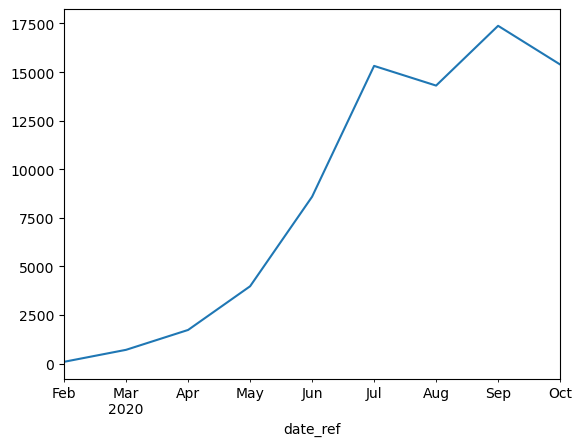

In [13]:
# CHAMADOS ABERTOS AO LONGO DO ANO
cases_ts['chamado'].groupby(cases_ts['date_ref'].dt.to_period('M')).sum().plot(kind='line')

In [14]:
creds_ts = creds[['id', 'cred_date']]
creds_ts['cred_date'] =  pd.to_datetime(creds_ts['cred_date'])
creds_ts['id'] =  creds_ts['id'].astype(int)

<AxesSubplot:xlabel='cred_date'>

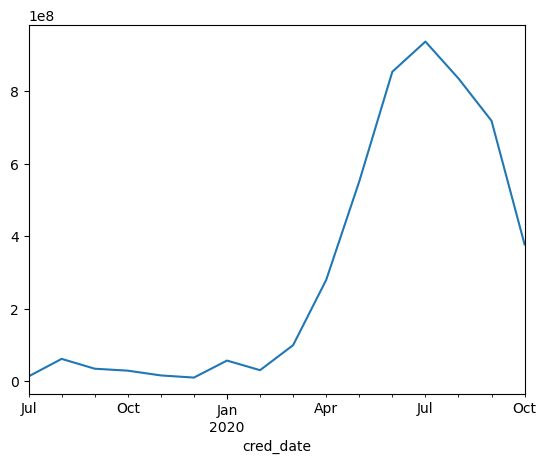

In [15]:
# CREDENCIAMENTOS AO LONGO DOS ANOS
creds_ts['id'].groupby(creds_ts['cred_date'].dt.to_period('M')).sum().plot(kind='line')

In [16]:
# SEPARANDO OS CHAMADOS PELOS MESES, EM ATENDIDOS OU N'AO ATENDIDOS
chamados = pd.read_sql('''SELECT CAST(DATE_TRUNC('month', CAST(date_ref AS DATE)) AS DATE) AS date_ref, 
                          COUNT(missed) 
                          FROM dbadmin.tb_cases 
                          WHERE TRUE 
                          AND date_ref <> ''
                          GROUP BY 1
                          ORDER BY 1 DESC
                      ''', engine) 

In [17]:
chamados

,date_ref,count
0,2020-10-01,15391
1,2020-09-01,17381
2,2020-08-01,14305
3,2020-07-01,15318
4,2020-06-01,8587
5,2020-05-01,3978
6,2020-04-01,1730
7,2020-03-01,708
8,2020-02-01,91


In [18]:
cases_creds = pd.read_sql('''
WITH cred AS (
	SELECT DATE_TRUNC('month', CAST(cred_date AS DATE)) AS dt_credenciamento,
	       accountid, 
		   COUNT(accountid) AS qtd_cred--ver accountid nulos 
	FROM dbadmin.tb_creds
	GROUP BY 1, 2
	),
	 cases AS (
	SELECT accountid, 
		   DATE_TRUNC('month', CAST(date_ref AS DATE)) AS dt_chamado, 
		   missed,
		   id
	FROM dbadmin.tb_cases
	WHERE TRUE 
	AND date_ref <> ''),
-------------------------
	 chamados AS (
	SELECT ca.dt_chamado,
	   	   COUNT(ca.missed) qtd_chamados,
	       cr.dt_credenciamento,
		   cr.qtd_cred
	FROM cases AS ca
	LEFT JOIN cred AS cr
		ON ca.accountid = cr.accountid
	GROUP BY 1, 3, 4
	ORDER BY 1 DESC)
-------------------------
	SELECT DISTINCT
		CAST(dt_chamado AS DATE) AS dt_chamado,
		SUM(qtd_chamados) qtd_chamados,
		SUM(qtd_cred) qtd_cred,
		ROUND((SUM(qtd_cred) / SUM(qtd_chamados))*100, 1) AS cred_por_chamados
	FROM chamados
	GROUP BY dt_chamado
	ORDER BY dt_chamado DESC
''', engine)

In [19]:
cases_creds

,dt_chamado,qtd_chamados,qtd_cred,cred_por_chamados
0,2020-10-01,15391.0,1556.0,10.1
1,2020-09-01,17381.0,1649.0,9.5
2,2020-08-01,14305.0,1652.0,11.5
3,2020-07-01,15318.0,1581.0,10.3
4,2020-06-01,8587.0,1201.0,14.0
5,2020-05-01,3978.0,870.0,21.9
6,2020-04-01,1730.0,660.0,38.2
7,2020-03-01,708.0,572.0,80.8
8,2020-02-01,91.0,138.0,151.6


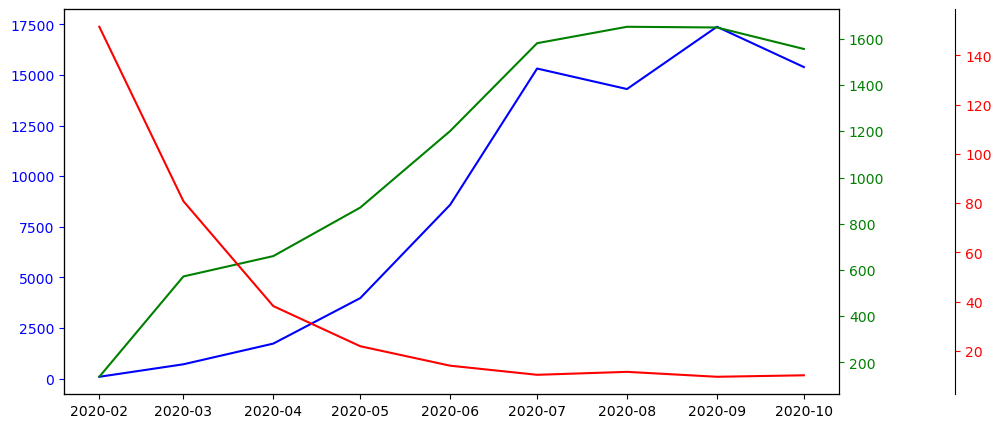

In [20]:
# CHAMADOS X CREDENCIAMENTOS X RAZAO NOVOS CREDENCIAMENTOS x NOVOS CHAMADOS
fig, ax1 = plt.subplots(figsize = (10, 5))

data = cases_creds['dt_chamado']
qtd_chamados = cases_creds['qtd_chamados']
qtd_creds = cases_creds['qtd_cred']
porc = cases_creds['cred_por_chamados']

ax1.plot(data, qtd_chamados, color = 'blue')

ax2 = ax1.twinx()
ax2.plot(data, qtd_creds, color = 'green')

ax3 = ax1.twinx()
ax3.plot(data, porc, color = 'red')
ax3.spines['right'].set_position(('axes', 1.15))

ax1.tick_params(axis = 'y', colors = "blue")
ax2.tick_params(axis = 'y', colors = "green")
ax3.tick_params(axis = 'y', colors = "red")

plt.show()

### Questão 2
Foi notado pelo nosso time que clientes recem credenciados possuem um comportamento específico em relação à quantidade de chamados realizados logo após seu credenciamento. 
Identifique e prepare alguma forma de visualizar essa diferença notada pelos agentes.

In [21]:
q2 = pd.read_sql('''
WITH cred AS (
	SELECT DATE_TRUNC('week', CAST(cred_date AS DATE)) AS dt_credenciamento,
	       accountid, 
		   COUNT(accountid) AS qtd_cred--ver accountid nulos 
	FROM dbadmin.tb_creds
	GROUP BY 1, 2
	),
	 cases AS (
	SELECT accountid, 
		   DATE_TRUNC('week', CAST(date_ref AS DATE)) AS dt_chamado, 
		   missed,
		   id
	FROM dbadmin.tb_cases
	WHERE TRUE 
	AND date_ref <> ''
	 ),
-------------------------
	 chamados AS (
	SELECT ca.dt_chamado,
	   	   COUNT(ca.missed) qtd_chamados,
	       cr.dt_credenciamento,
		   cr.qtd_cred
	FROM cases AS ca
	LEFT JOIN cred AS cr
		ON ca.accountid = cr.accountid
	GROUP BY 1, 3, 4
	ORDER BY 1 DESC),
-------------------------
	  mes_anterior AS (
	 SELECT dt_chamado,
		LAG(dt_chamado,1) OVER (
			ORDER BY dt_chamado
			) mes_anterior
	 FROM chamados
	 GROUP BY dt_chamado
	 ORDER BY dt_chamado DESC)
-------------------------
	SELECT CAST(c.dt_chamado AS DATE) AS dt_chamado, 
		   SUM(c.qtd_chamados) qtd_chamados, 
		   SUM(c.qtd_cred) qtd_credeciamentos, 
		   --CAST(c.dt_credenciamento AS DATE) AS dt_credenciamento, 
		   --CAST(m.mes_anterior AS DATE) AS mes_anterior,
		   LAG(SUM(qtd_chamados),1) OVER (
			ORDER BY c.dt_chamado
			) qtd_chamados_lag,
		   LAG(SUM(qtd_cred),1) OVER (
			ORDER BY c.dt_chamado
			) qtd_cred_lag
	FROM chamados c
	LEFT JOIN mes_anterior m
		ON c.dt_chamado = m.dt_chamado
	WHERE TRUE
	AND c.dt_credenciamento = m.mes_anterior
	GROUP BY c.dt_chamado--, --c.dt_credenciamento, m.mes_anterior, 
		     --c.qtd_chamados, c.qtd_cred
	ORDER BY c.dt_chamado ASC--, c.dt_credenciamento DESC
''', engine)

In [22]:
q2.head()

,dt_chamado,qtd_chamados,qtd_credeciamentos,qtd_chamados_lag,qtd_cred_lag
0,2020-02-24,16.0,18.0,NaN,NaN
1,2020-03-02,15.0,32.0,16.0,18.0
2,2020-03-09,52.0,43.0,15.0,32.0
3,2020-03-16,11.0,16.0,52.0,43.0
4,2020-03-23,12.0,15.0,11.0,16.0


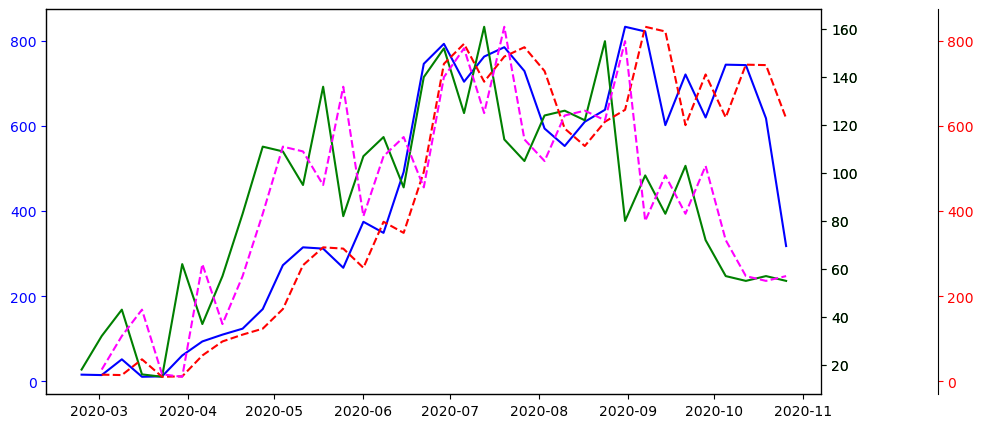

In [23]:
# 
fig, ax1 = plt.subplots(figsize = (10, 5))

dt_chamado = q2['dt_chamado']
qtd_chamados = q2['qtd_chamados']
qtd_credeciamentos = q2['qtd_credeciamentos']
qtd_chamados_lag = q2['qtd_chamados_lag']
qtd_cred_lag = q2['qtd_cred_lag']

ax1.plot(dt_chamado, qtd_chamados, color = 'blue')

ax2 = ax1.twinx()
ax2.plot(dt_chamado, qtd_credeciamentos, color = 'green')

ax3 = ax1.twinx()
ax3.plot(dt_chamado, qtd_chamados_lag, '--', color = 'red')
ax3.spines['right'].set_position(('axes', 1.15))

ax4 = ax1.twinx()
ax4.plot(dt_chamado, qtd_cred_lag, '--',color = 'magenta')
#ax4.spines['left'].set_position(('axes', 1.15))

ax1.tick_params(axis = 'y', colors = "blue")
ax2.tick_params(axis = 'y', colors = "green")
ax3.tick_params(axis = 'y', colors = "red")
#ax4.tick_params(axis = 'y', colors = "magenta")

plt.show()

### Questão 3
Para conseguir melhorar a qualidade do nosso atendimento ao cliente, foi proposto que a alguns chamados tenham prioridade de atendimento. 
Levando em consideração o motivo dos chamados, como você estabeleceria essa prioridade da fila de espera? 

In [24]:
q3 = pd.read_sql(''' 
SELECT DISTINCT 
		   CAST(DATE_TRUNC('month', dt_chamado) AS DATE) AS dt_chamado, 
		   month,
	       motivo, max_machine,
		   SUM(qtd_chamados) AS qtd_chamados
FROM dbadmin.vw_cluster
WHERE TRUE
--AND dt_chamado >= '2020-08-01'
GROUP BY 1, 2, 3, 4
ORDER BY 1 ASC
-------------------------
''', engine)

In [25]:
q3.head()

,dt_chamado,month,motivo,max_machine,qtd_chamados
0,2020-02-01,February,Aplicativo,T1,20.0
1,2020-02-01,February,Aplicativo,T2,2.0
2,2020-02-01,February,Aplicativo,T3,3.0
3,2020-02-01,February,Cadastro,T1,3.0
4,2020-02-01,February,Cadastro,T3,1.0


In [26]:
q3['max_machine'] =  q3['max_machine'].astype('category')
q3['motivo'] =  q3['motivo'].astype('category')
q3['qtd_chamados'] =  q3['qtd_chamados'].astype('int')

In [27]:
q3.dtypes

dt_chamado        object
month             object
motivo          category
max_machine     category
qtd_chamados       int32
dtype: object

In [28]:
# Criando Clusters baseados em Produto Adquirido e Motivo do Chamado
#from sklearn.preprocessing import LabelEncoder
#import numpy as np

In [29]:
#X = q3.iloc[:, 0:2].values
#y = q3.iloc[:,2].values

In [30]:
#label_encoder = LabelEncoder()
#X[:,0] = label_encoder.fit_transform(X[:,0])
#X[:,1] = label_encoder.fit_transform(X[:,1])

In [31]:
#from sklearn.cluster import KMeans
#elbw = []
#for i in range(1,6):
#    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0)
#    kmeans.fit(X)
#    elbw.append(kmeans.inertia_)

In [32]:
#plt.plot(range(1, 6), elbw)
#plt.title('Elbow Method')
#plt.show()

In [33]:
#kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0)
#y_kmeans = kmeans.fit_predict(X)

In [34]:
#y_kmeans

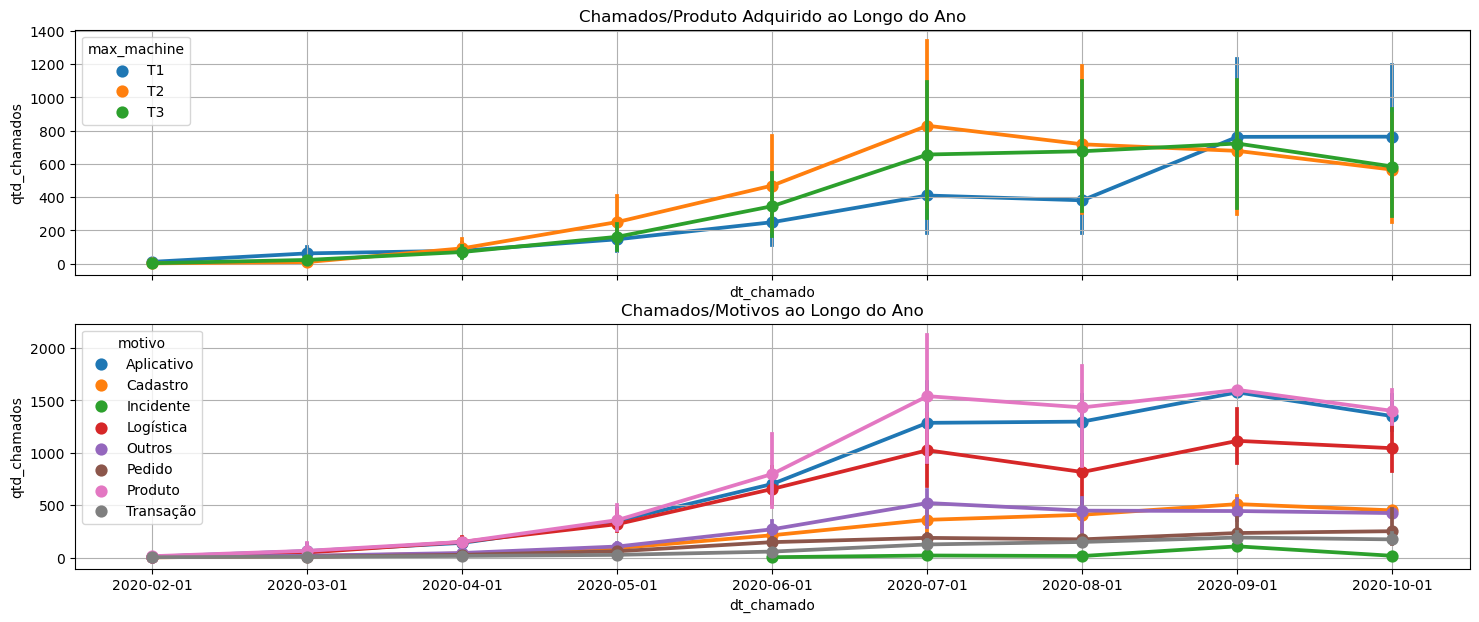

In [35]:
# tendências chamados
_, ax = plt.subplots(nrows = 2, sharex = True, figsize = (18, 7))

sns.pointplot(data = q3, x = 'dt_chamado', y = 'qtd_chamados', hue = 'max_machine', ax = ax[0])
ax[0].set_title("Chamados/Produto Adquirido ao Longo do Ano")
ax[0].grid()

sns.pointplot(data = q3, x = 'dt_chamado', y = 'qtd_chamados', hue = 'motivo', ax = ax[1])
ax[1].set_title("Chamados/Motivos ao Longo do Ano")
ax[1].grid();

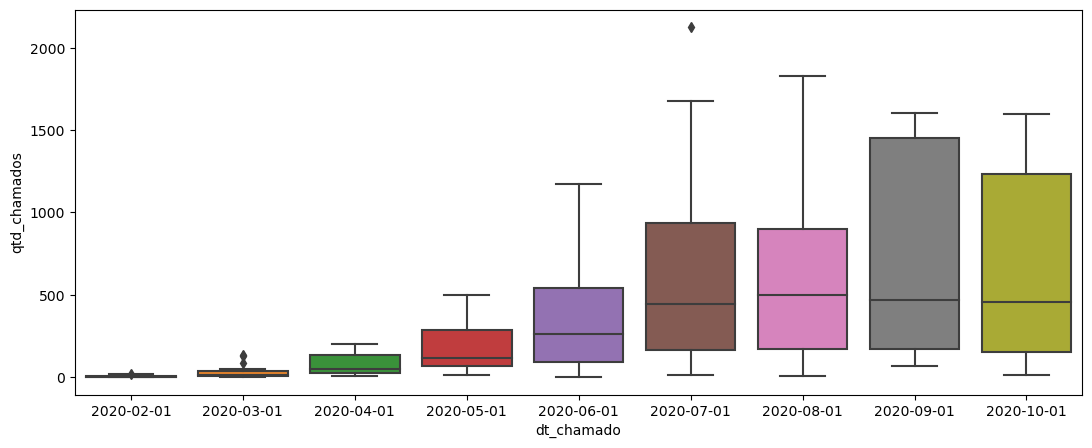

In [37]:
# Distribuicao chamados
fig, ax = plt.subplots(figsize = (13, 5))
sns.boxplot(data=q3, x="dt_chamado", y="qtd_chamados");

### Questão 4
Escreva duas queries em SQL que retornem:
i) o volume de chamados por semana dos últimos três meses para cada cluster de clientes proposto na questão 3.
ii) uma série histórica dia a dia, que para cada dia retorne o número de chamados referentes aos últimos 30 dias (por exemplo, para o dia 30/01, a query deve retornar a quantidade de chamados totais entre os dias 01/01 e 30/01)

In [39]:
q4_1 = pd.read_sql(''' 
-- i) o volume de chamados por semana dos últimos três meses para cada cluster de clientes proposto na questão 3.
SELECT DISTINCT 
		   CAST(DATE_TRUNC('week', dt_chamado) AS DATE) AS dt_chamado,
	       motivo, max_machine,
		   SUM(qtd_chamados) AS qtd_chamados
FROM dbadmin.vw_cluster
WHERE TRUE
AND dt_chamado >= '2020-08-01'
AND motivo IN ('Aplicativo', 'Logística', 'Produto')
GROUP BY 1, 2, 3
ORDER BY 1 ASC
-------------------------
''', engine)

In [40]:
q4_1

,dt_chamado,motivo,max_machine,qtd_chamados
0,2020-07-27,Aplicativo,T1,13.0
1,2020-07-27,Aplicativo,T2,34.0
2,2020-07-27,Aplicativo,T3,36.0
3,2020-07-27,Logística,T1,10.0
4,2020-07-27,Logística,T2,17.0
...,...,...,...,...
121,2020-10-26,Logística,T2,130.0
122,2020-10-26,Logística,T3,161.0
123,2020-10-26,Produto,T1,199.0
124,2020-10-26,Produto,T2,202.0


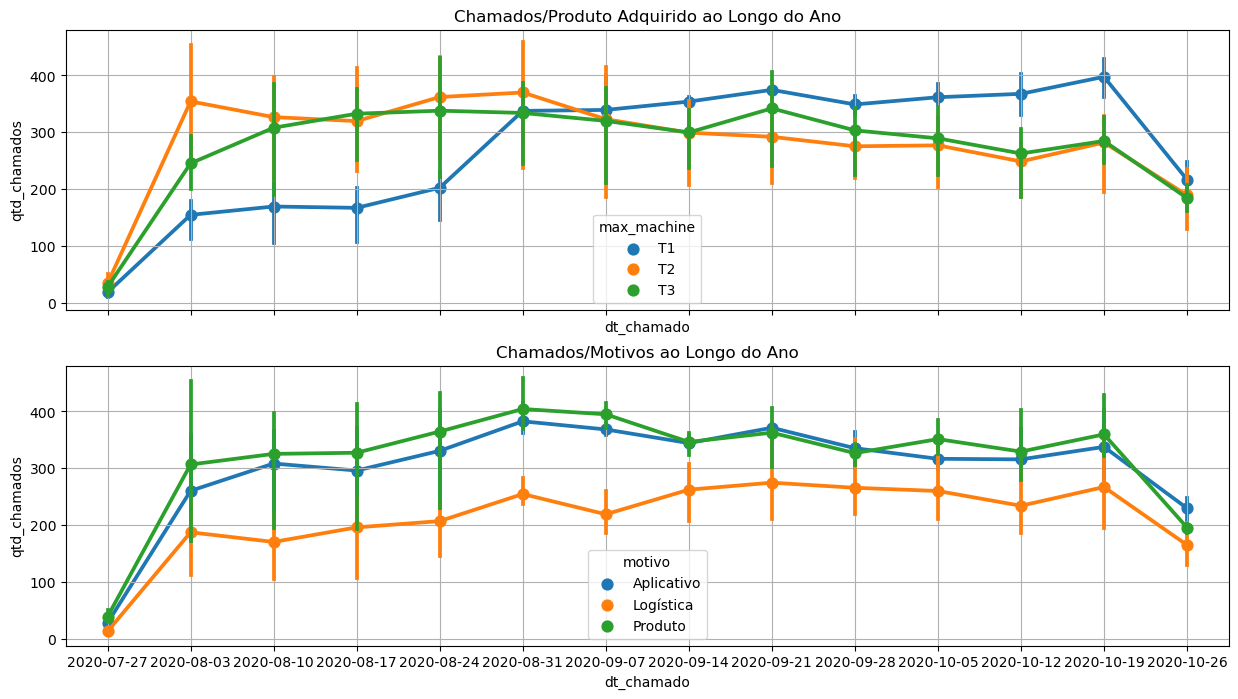

In [41]:
# tendências chamados
_, ax = plt.subplots(nrows = 2, sharex = True, figsize = (15, 8))

sns.pointplot(data = q4_1, x = 'dt_chamado', y = 'qtd_chamados', hue = 'max_machine', ax = ax[0])
ax[0].set_title("Chamados/Produto Adquirido ao Longo do Ano")
ax[0].grid()

sns.pointplot(data = q4_1, x = 'dt_chamado', y = 'qtd_chamados', hue = 'motivo', ax = ax[1])
ax[1].set_title("Chamados/Motivos ao Longo do Ano")
ax[1].grid()

In [42]:
q4_2 = pd.read_sql(''' 
-- ii) uma série histórica dia a dia, que para cada dia retorne o número de chamados referentes aos últimos 30 dias
SELECT DISTINCT 
		   CAST(DATE_TRUNC('day', dt_chamado) AS DATE) AS dt_chamado,
	       motivo, max_machine,
		   SUM(qtd_chamados) AS qtd_chamados
FROM dbadmin.vw_cluster
WHERE TRUE
AND dt_chamado >= '2020-10-01'
AND motivo IN ('Aplicativo', 'Logística', 'Produto')
GROUP BY 1, 2, 3
ORDER BY 1 ASC
-------------------------
''', engine)

In [43]:
q4_2

,dt_chamado,motivo,max_machine,qtd_chamados
0,2020-10-01,Aplicativo,T1,62.0
1,2020-10-01,Aplicativo,T2,56.0
2,2020-10-01,Aplicativo,T3,57.0
3,2020-10-01,Logística,T1,60.0
4,2020-10-01,Logística,T2,39.0
...,...,...,...,...
256,2020-10-29,Logística,T2,34.0
257,2020-10-29,Logística,T3,50.0
258,2020-10-29,Produto,T1,48.0
259,2020-10-29,Produto,T2,45.0


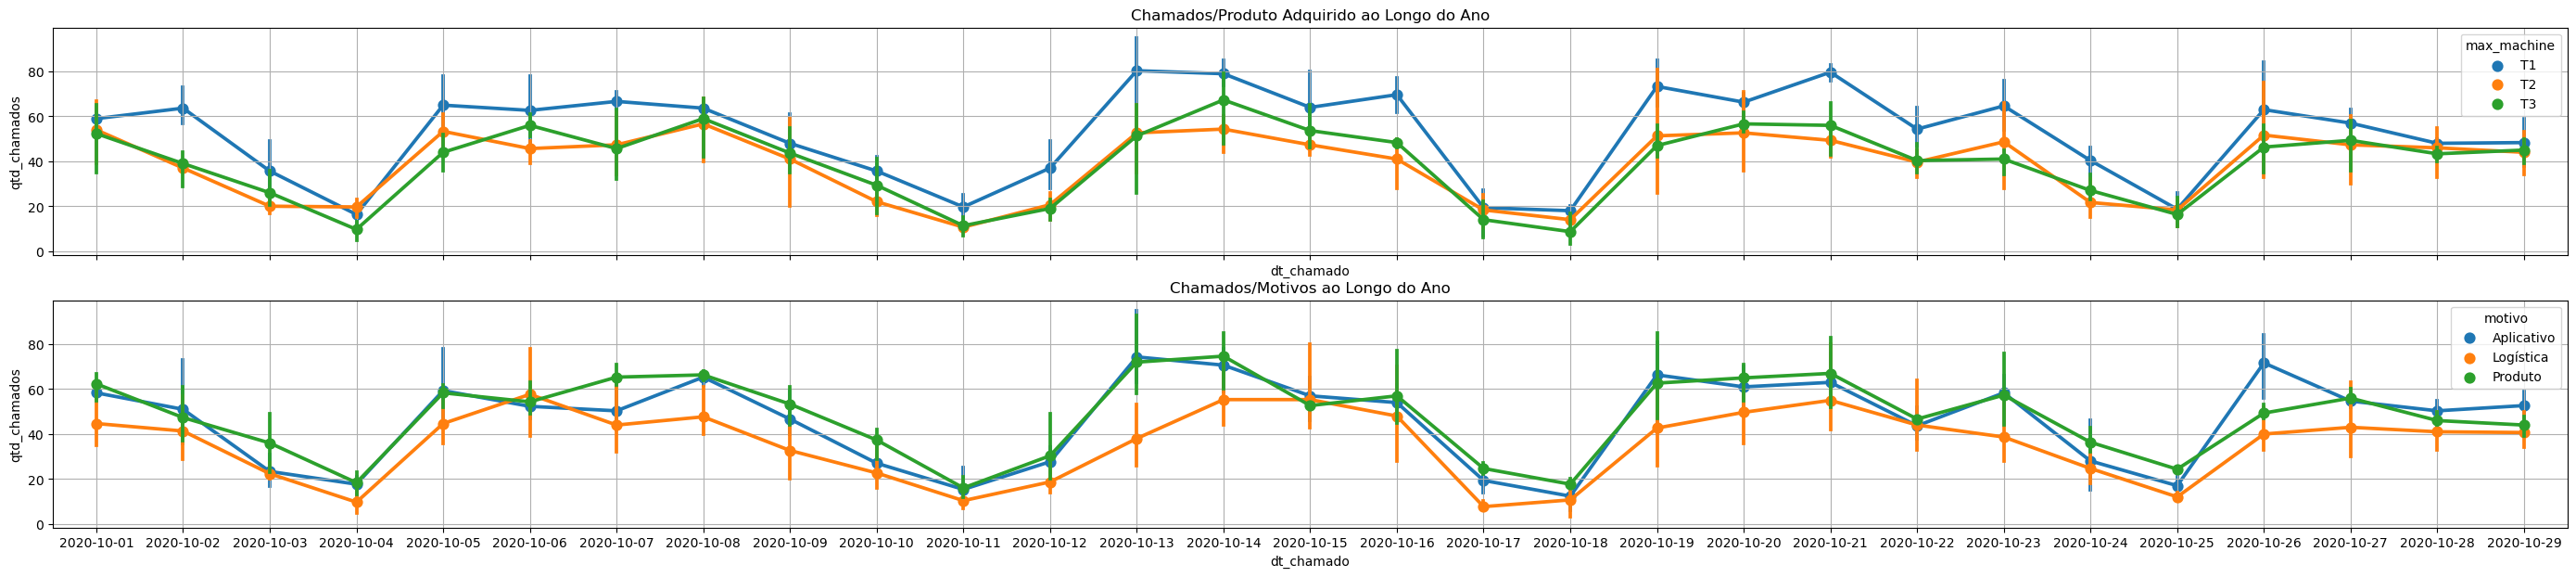

In [44]:
# tendências chamados
_, ax = plt.subplots(nrows = 2, sharex = True, figsize = (35, 7))

sns.pointplot(data = q4_2, x = 'dt_chamado', y = 'qtd_chamados', hue = 'max_machine', ax = ax[0])
ax[0].set_title("Chamados/Produto Adquirido ao Longo do Ano")
ax[0].grid()

sns.pointplot(data = q4_2, x = 'dt_chamado', y = 'qtd_chamados', hue = 'motivo', ax = ax[1])
ax[1].set_title("Chamados/Motivos ao Longo do Ano")
ax[1].grid()

### Questão 5
Questão de estudo livre: Como é esperado de um analista de dados, traga insights relevantes sobre pontos de atenção e possíveis melhorias que você identificou ao analisar ambas as bases de dados. 
Além disso faça pelo menos duas perguntas relacionadas aos dados que julgue relevantes para análise, você também pode sugerir outros dados para enriquecer os aqui disponibilizados.